# Importing the packages

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.misc import imread , imresize
import os
import time

# Parameters

In [4]:
hidden_nodes = 1024
lr = 1e-3
lr_kl = 0.1
epochs = 300
sparsity = 0.2

# Declaring functions

In [5]:
# Sigmoid

def sigmoid(x):
    return 1/(1 + np.exp(-x))

#derivative of sigmoid
def deriv_sigmoid(x):
    return np.exp(-x)/((1+ np.multiply(np.exp(-x),np.exp(-x))))

# softmax

def softmax(x):
    out = np.zeros(x.shape)
    for i in range(0,x.shape[0]):
        for j in range(0,x.shape[1]):
            out[i,j] = np.exp(x[i,j])/np.sum(np.exp(x[i]))
    return out

# sum of Squared error

def squared_error(y_train, y_predicted):
    return np.sum(np.multiply(y_train - y_predicted , y_train - y_predicted))

In [6]:
def load_flattened_images(Loc):
    Images = []
    for root, dirs, files in os.walk(Loc):
        for file in files:
            Image = imread(os.path.join(root, file))
#             Image = imresize(Image, (14,14))
            Image = np.round(Image / 255.0)
#             Image = Image/255.0
            Images.append(Image.flatten())
                
    Images = np.asmatrix(Images)
    print(Images.shape)

    return Images

In [7]:
## fitting the model

def net_fit(x_train , y_train , epochs = 100 , hidden_nodes = 2 , lr = 1e-3 , lr_kl = 1e-2):
    input_dim = x_train.shape[1]
    training_samples = x_train.shape[0]
    output_dim = y_train.shape[1]
    costs = []
    z_means = []
    x_train = np.hstack((np.ones((training_samples , 1)), x_train))
    #initializig the parameters
    alpha = np.asmatrix(np.random.normal(0,1,(input_dim + 1 , hidden_nodes)))
    beta = np.asmatrix(np.random.normal(0,1,(hidden_nodes+1 , output_dim)))
    
    #looping for number of itretions
    for epoch in range(0,epochs):
        #finding z matrix
        z_raw = x_train * alpha 
        z = sigmoid(z_raw)
        z_biased = np.asmatrix(np.hstack((np.ones((training_samples,1)),z)))
        
        #finding y matrix
        y_raw = z_biased * beta
        y_predicted = sigmoid(y_raw)
        
        ##finding the cost
        cost = squared_error(y_train , y_predicted) + lr_kl * np.sum((sparsity*np.log(sparsity/np.mean(z , axis = 0))) + ((1-sparsity)*np.log((1-sparsity)/(1-np.mean(z , axis = 0)))))
        costs.append(cost)
        z_means.append(np.mean(z))
        #finding gradient w.r.t beta
        delta = np.multiply((y_predicted - y_train), deriv_sigmoid(y_raw))
        d_beta = z_biased.T * delta
       
        temp_beta = beta[1:,:]
        
        #finding gradient w.r.t alpha
        ss = np.multiply((delta * temp_beta.T),deriv_sigmoid(z_raw))
        d_alpha_raw = x_train.T * ss
#         kl divergence derivative
        d_kl = t = np.repeat(((-sparsity/np.mean(z , axis = 0)) + ((1-sparsity)/(1-np.mean(z , axis = 0)))).reshape(1,hidden_nodes) , training_samples , axis = 0)
        d_alpha_kl = (1/training_samples)*(x_train.T * d_kl)
        d_alpha = d_alpha_raw + lr_kl*d_alpha_kl
#         print(np.max(d_alpha) ,np.max(d_alpha_raw) ,np.max(d_kl) , np.max(d_beta) )
        
        #updating the weights
        beta = beta - lr * d_beta
        alpha = alpha - lr*d_alpha
#         print(np.max(alpha) , np.max(beta) , np.min(alpha) , np.min(beta))
        print("\nEpoch: " + str(epoch+1) + "   cost : " + str(cost))
    return alpha , beta , costs , z_means

In [8]:
#prediction

def net_predict(x_test , alpha , beta ):
    testing_samples = x_test.shape[0]
    #adding bias
    x_test = np.hstack((np.ones((testing_samples , 1)), x_test))
    
    #finding z matrix
    z_raw = x_test * alpha
    z = sigmoid(z_raw)
    z_biased = np.asmatrix(np.hstack((np.ones((testing_samples,1)),z)))
    
    #finding Y matrix (predicting the outputs)
    y_raw = z_biased * beta
    y_predicted = sigmoid(y_raw)
    y_predicted = np.round(y_predicted)   ##comment it if solving for regression
    return y_predicted

# Generating training data

In [9]:
x_train = np.load("train_set_10000.npy")
print(x_train.shape)

(10000, 784)


# Training the Model

In [8]:
# alpha , beta , losses = net_fit(x_Train , y_train_and , hidden_nodes = hidden_nodes , epochs = epochs ,lr = lr)
tic = time.time()
alpha , beta , losses , means = net_fit(x_train , x_train , hidden_nodes = hidden_nodes , epochs = epochs ,lr = lr , lr_kl = lr_kl)
print("time taken: "+ str(time.time() - tic) + "sec")
# print("\nalpha:\n",alpha ,"\nbeta:\n", beta,"\n" ,"\nloss:\n", losses[epochs-1])
np.save("alpha_weights_sae_v3.npy" , alpha)
np.save("beta_weights_sae_v3.npy" , beta)


Epoch: 1   cost : 3749975.1240937985

Epoch: 2   cost : 1732414.2990460221

Epoch: 3   cost : 1387607.0583543826

Epoch: 4   cost : 1283996.197665262

Epoch: 5   cost : 1239307.9386880898

Epoch: 6   cost : 1197261.482165411

Epoch: 7   cost : 1164719.6726035767

Epoch: 8   cost : 1146539.966538277

Epoch: 9   cost : 1139502.8990229573

Epoch: 10   cost : 1142009.3825962397

Epoch: 11   cost : 1141286.6243754707

Epoch: 12   cost : 1108461.6453047248

Epoch: 13   cost : 1097915.8491551585

Epoch: 14   cost : 1085768.9716136083

Epoch: 15   cost : 1070094.3133000263

Epoch: 16   cost : 1046455.7990944402

Epoch: 17   cost : 1030148.5720348607

Epoch: 18   cost : 1010312.5656559073

Epoch: 19   cost : 994362.5219796746

Epoch: 20   cost : 975356.2583921864

Epoch: 21   cost : 938314.3045812914

Epoch: 22   cost : 927365.1683781347

Epoch: 23   cost : 917289.7880284699

Epoch: 24   cost : 891215.6263387204

Epoch: 25   cost : 865137.5550137769

Epoch: 26   cost : 858508.4019092204

Epoch


Epoch: 213   cost : 310875.79273686477

Epoch: 214   cost : 304053.4730249038

Epoch: 215   cost : 298699.06649218465

Epoch: 216   cost : 286042.98507641023

Epoch: 217   cost : 283191.9231399913

Epoch: 218   cost : 275336.83809866814

Epoch: 219   cost : 275740.96113174135

Epoch: 220   cost : 271252.46196106053

Epoch: 221   cost : 276756.47321848426

Epoch: 222   cost : 273110.04057747126

Epoch: 223   cost : 279547.069499292

Epoch: 224   cost : 275105.8817193453

Epoch: 225   cost : 277880.7619321681

Epoch: 226   cost : 273243.5718522008

Epoch: 227   cost : 274647.30210426747

Epoch: 228   cost : 267755.78276523505

Epoch: 229   cost : 268097.31233959756

Epoch: 230   cost : 262501.63790427794

Epoch: 231   cost : 261287.9961483633

Epoch: 232   cost : 257559.77530698327

Epoch: 233   cost : 257221.01563910895

Epoch: 234   cost : 257061.71408171084

Epoch: 235   cost : 258160.76165858615

Epoch: 236   cost : 263477.37446424563

Epoch: 237   cost : 269837.1494976071

Epoch: 2

### Predicting

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """


(350, 784)


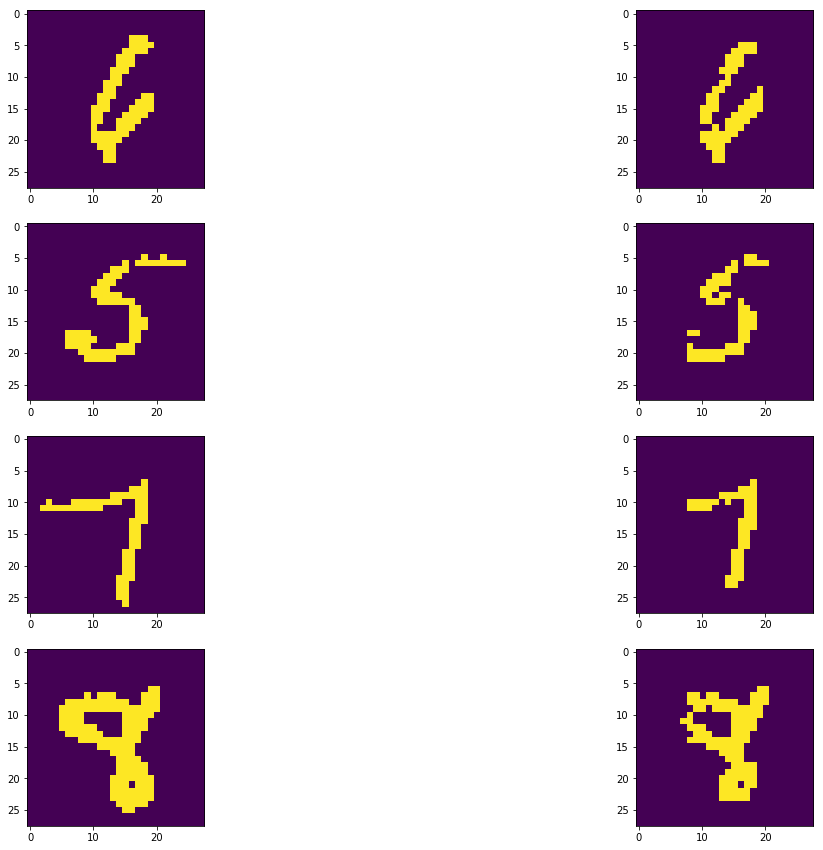

In [20]:
#testing samples
alpha = np.load("alpha_weights_sae_v3.npy")
beta = np.load("beta_weights_sae_v3.npy")
# x_test = load_flattened_images("/home/snehith/Documents/machine learning/datasets/mnist/mnistasjpg/testSample/")
# np.save("test_set_350.npy" , x_test)
x_test = np.asmatrix(np.load("test_set_350.npy"))
#predicting the output
res = net_predict(x_test , alpha , beta)
# print(losses.shape)
plt.figure(figsize = (20,15))
for i in range(0,4):
    plt.subplot(4,2,2*i+1)
    plt.imshow(x_test[i].reshape(28,28))
    plt.subplot(4,2,2*i+2)
    plt.imshow(res[i].reshape(28,28))

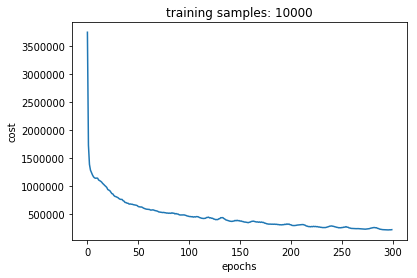

In [10]:
#ploting the cost vs epochs
plt.plot(np.arange(epochs),losses)
plt.title("training samples: " + str(x_train.shape[0]))
plt.xlabel("epochs")
plt.ylabel("cost")
plt.show()